# Base Imports

In [1]:
import importlib
import logging
importlib.reload(logging)
logging.basicConfig(level=logging.INFO)

logging.getLogger("rosetta").setLevel(logging.WARNING)

In [2]:
import toolz
from toolz import first

In [3]:
import pyrosetta.distributed

In [4]:
import tmol.tests.data

In [5]:
import tmol.system.io
import tmol.score
import torch
import tmol.score.ljlk.jit_score_graph
import tmol.score.ljlk.cpp_potential

In [6]:
from tmol.utility.reactive import reactive_attrs, reactive_property

# Rosetta Scoring

Benchmark rosetta scoring performance by structure size.

In [7]:
decoys = tmol.tests.data.structures_bysize()

In [8]:
from tmol.tests.benchmark import subfixture, make_subfixture, make_fixture, stat_frame

rosetta_score_results = []

for n, d in decoys.items():

    work_pose = d.stripped_pose.pose
    if len(work_pose.residues) > 400:
        continue
        
    logging.info(n)

    fixture = make_fixture(
        "score", rosetta_score_results.append, nres=len(work_pose.residues), natoms = len(d.tmol_coords), model=n
    )

    logging.info("Rosetta")
    atr_rep_sf = pyrosetta.get_score_function()
    for k, v in pyrosetta.rosetta.core.scoring.ScoreType.__members__.items():
        if k not in ("fa_atr", "fa_rep"):
            atr_rep_sf.set_weight(v, 0)

    @subfixture(fixture, impl="rosetta")
    def rosetta_atr_rep():
        work_pose.energies().clear()
        return atr_rep_sf(work_pose)

    @reactive_attrs
    class TMolJitLJLK(
        tmol.score.ljlk.jit_score_graph.JitLJLKScoreGraph,
        tmol.score.coordinates.CartesianAtomicCoordinateProvider,
        tmol.score.bonded_atom.BondedAtomScoreGraph,
        tmol.score.device.TorchDevice,
    ):
        pass

    score_graphs = dict(
        tmol_lj_cpu_cpp=TMolJitLJLK.build_for(
            d.tmol_system, requires_grad=False, lj_jit_type="cpp"
        ),
        #tmol_lj_cuda_cpp=TMolJitLJLK.build_for(
        #    d.tmol_system,
        #    device=torch.device("cuda"),
        #    requires_grad=False,
        #    lj_jit_type="cpp",
        #),
    )

    scores = {}

    for n, sg in score_graphs.items():
        logging.info(f"{n}")
        # Setup graph
        sg.intra_score().total_lj
        
        for ptype in tmol.score.ljlk.cpp_potential.potentials:
            tmol.score.ljlk.cpp_potential.POTENTIAL_SET = ptype

            @make_subfixture(fixture, f".{n}.{ptype}", device=sg.device.type)
            def benchmark_score_graph():
                sg.coords = sg.coords
                return float(sg.intra_score().total_lj)

        scores[n] = benchmark_score_graph

    del score_graphs
    torch.cuda.empty_cache()

    tmol_scores = " ".join(f"{n}: {v}" for n, v in scores.items())

    logging.info(f"rosetta: {rosetta_atr_rep} {tmol_scores}")


INFO:pyrosetta.distributed:maybe_init performing pyrosetta initialization: {'extra_options': '-out:levels all:warning'}
INFO:root:BYSIZE_100_RES_5UMR
INFO:root:Rosetta
INFO:root:tmol_lj_cpu_cpp
INFO:root:rosetta: -440.40303847870354 tmol_lj_cpu_cpp: -370.7062072753906
INFO:root:BYSIZE_150_RES_5YZF
INFO:root:Rosetta
INFO:root:tmol_lj_cpu_cpp
INFO:root:rosetta: -752.441272221159 tmol_lj_cpu_cpp: -353.4836120605469
INFO:root:BYSIZE_200_RES_5MM8
INFO:root:Rosetta
INFO:root:tmol_lj_cpu_cpp
INFO:root:rosetta: -954.3679023401932 tmol_lj_cpu_cpp: -690.8179321289062
INFO:root:BYSIZE_250_RES_5N5G
INFO:root:Rosetta
INFO:root:tmol_lj_cpu_cpp
INFO:root:rosetta: -1119.8932213914081 tmol_lj_cpu_cpp: -716.1956176757812
INFO:root:BYSIZE_300_RES_6F8B
INFO:tmol.system.io.ResidueReader:missing atoms in input: {'HG'}
INFO:tmol.system.io.ResidueReader:missing atoms in input: {'HG'}
INFO:tmol.system.io.ResidueReader:missing atoms in input: {'HG'}
INFO:tmol.system.io.ResidueReader:missing atoms in input: {'HG

In [9]:
from matplotlib import pyplot
import seaborn
import pandas

In [10]:
dat = stat_frame(rosetta_score_results)
dat = pandas.concat(
    (
        dat,
        pandas.merge(
            dat,
            dat.query("name == 'score.rosetta_atr_rep'").groupby("model").time.mean().rename("rosetta_mean").to_frame(),
            left_on="model",
            right_index=True
        ).eval("time / rosetta_mean").rename("rosetta_relative")
    ),
    axis=1
)

In [11]:
dat["Platform"] = "cpu"
dat["Platform"][dat.name.str.contains("cuda")] = "cuda"

dat["Implementation"] = dat["impl"]
for ptype in tmol.score.ljlk.cpp_potential.potentials:
    dat["Implementation"][dat.name.str.contains(ptype)] = ptype


/home/fordas/.conda/envs/tmol/lib/python3.6/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app
/home/fordas/.conda/envs/tmol/lib/python3.6/site-packages/ipykernel/__main__.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


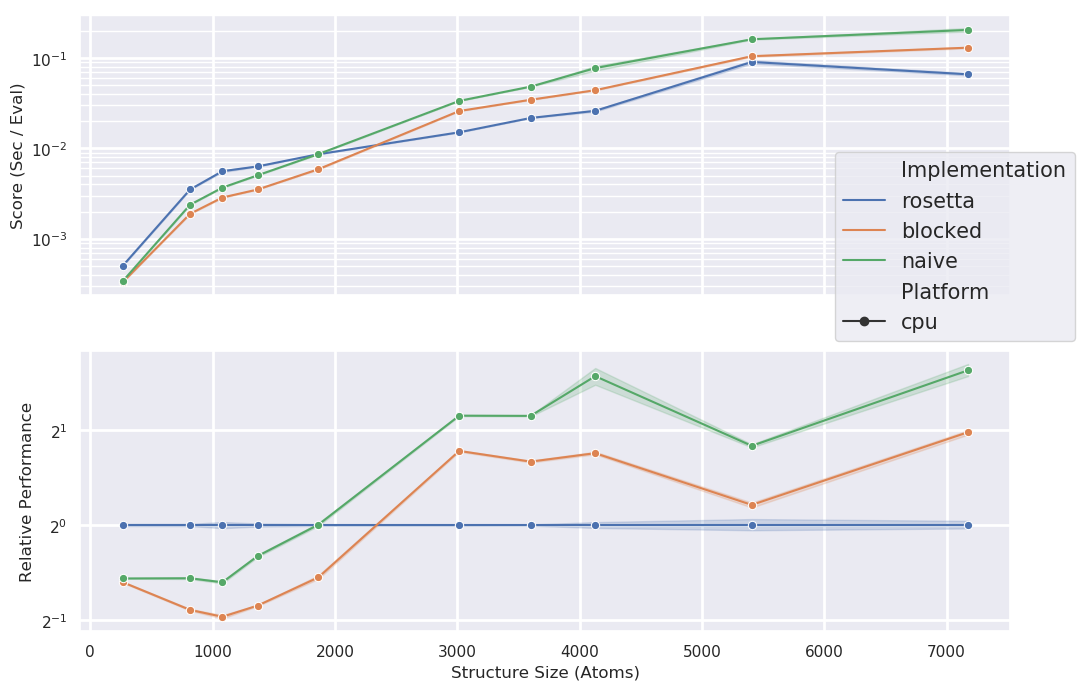

In [12]:
fdat = dat

fdat["Structure Size (Atoms)"] = fdat["natoms"]
fdat["Score (Sec / Eval)"] = fdat["time"]
fdat["Relative Performance"] = fdat["rosetta_relative"]

f, (a1, a2) = pyplot.subplots(2, sharex=True, squeeze=True, figsize=(12, 8))

#pyplot.xscale("log", basex=10)

seaborn.set(font_scale=1.5)

pyplot.sca(a1)
pyplot.yscale("log", basey=10)
pyplot.grid(True, "major", linewidth=2)
pyplot.grid(True, "minor")
seaborn.lineplot("Structure Size (Atoms)", "Score (Sec / Eval)", data=fdat, hue="Implementation", style="Platform", markers=True, legend=False)

pyplot.sca(a2)
pyplot.yscale("log", basey=2)
pyplot.grid(True, "major", linewidth=2)
pyplot.grid(True, "minor")
seaborn.lineplot("Structure Size (Atoms)", "Relative Performance", data=fdat, hue="Implementation", style="Platform", markers=True, legend="brief")
pyplot.legend(bbox_to_anchor=(.8, 1.), fontsize="small")

In [13]:
display((
    dat.query("name=='score.rosetta_atr_rep'")
    .groupby("natoms")[["time"]]
    .describe().reorder_levels((1, 0), axis=1)[["mean", "max", "std"]]
))

display((dat
    .groupby(("natoms", "name"))[["rosetta_relative", "time"]]
    .describe()
    .reorder_levels((1, 0), axis=1)["mean"]
    .xs("score.tmol_lj_cpu_cpp.blocked", level=1)
    .eval("fold_acceleration = rosetta_relative ** -1")
))

,mean,max,std
,time,time,time
natoms,,,
264,0.000500,0.001915,0.000066
816,0.003515,0.006250,0.000215
1080,0.005599,0.008471,0.000741
1368,0.006327,0.009032,0.000399
1864,0.008631,0.010000,0.000247
3016,0.015099,0.016018,0.000338
3600,0.021752,0.022631,0.000298
4128,0.026090,0.029624,0.001643


,rosetta_relative,time,fold_acceleration
natoms,,,
264,0.659019,0.000330,1.517406
816,0.538014,0.001891,1.858689
1080,0.511532,0.002864,1.954913
1368,0.555259,0.003513,1.800960
1864,0.682158,0.005887,1.465937
3016,1.720081,0.025972,0.581368
3600,1.590797,0.034604,0.628616
4128,1.691853,0.044141,0.591068
5408,1.159179,0.105020,0.862680
